# Episode 4 - Primitives

### Estimator primitive

Computes expectation values of observables with the respective states prepared by quantum circuits

### Sampler primitive

Returns shot by shot bit strings sampled from the probability distribution of the quantum stated prepared on the device.


# Transverse field Ising model to demo primitives

In [7]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import YGate, UnitaryGate
import numpy as np

SYGate = UnitaryGate(YGate().power(1/2), label=r"$\sqrt{Y}$")
SYdgGate = UnitaryGate(SYGate.inverse(), label=r"$\sqrt{Y}^\dag$")

def generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, num_cl_bits = 0, trotter_barriers = False, layer_barriers = False):
    if num_cl_bits == 0:
        qc = QuantumCircuit(num_qubits)
    else:
        qc = QuantumCircuit(num_qubits, num_cl_bits)

    for trotter_step in range(num_trotter_steps):
        add_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers)
        if trotter_barriers:
            qc.barrier()

    return qc

def add_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers = False):
    # Adding Rzz gates in the even layers
    for i in range(0, qc.num_qubits-1, 2):
        qc.sdg([i, i+1])
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate,[i+1])
    if layer_barriers:
        qc.barrier()
    # Adding Rzz gates in the odd layers
    for i in range(1, qc.num_qubits-1, 2):
        qc.sdg([i, i+1])
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate,[i+1])
    if layer_barriers:
        qc.barrier()
    qc.rx(rx_angle, list(range(qc.num_qubits)))
    if layer_barriers:
        qc.barrier()
    

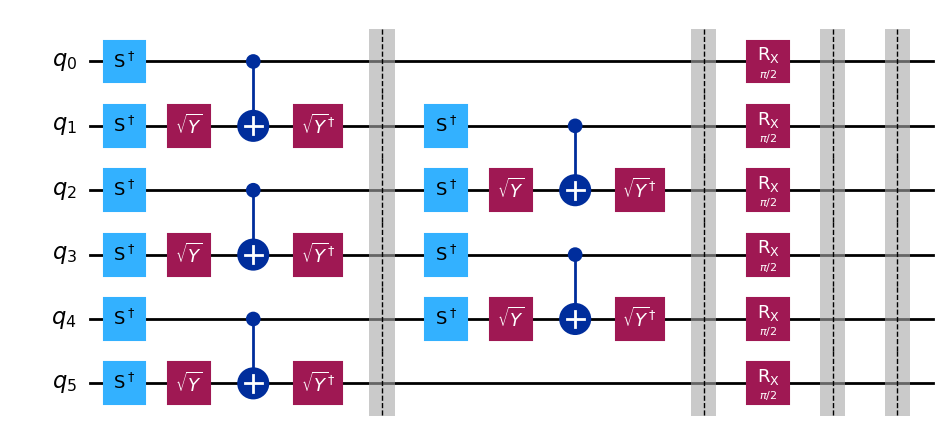

In [12]:
num_qubits = 6
num_trotter_steps = 1
rx_angle = 0.5 * np.pi

qc = generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True)

qc.draw(output='mpl', fold=1)

## Demo: Sampler

In [13]:
def append_mirrored_1d_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers = False, layer_barriers = False):

    for trotter_step in range(num_trotter_steps):
        add_mirrored_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers)
        if trotter_barriers:
            qc.barrier()

    return qc

def add_mirrored_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers = False):
    qc.rx(-rx_angle, list(range(qc.num_qubits)))
    if layer_barriers:
        qc.barrier()
    # Adding Rzz gates in the odd layers
    for i in range(1, qc.num_qubits-1, 2):
        qc.append(SYGate,[i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
        qc.s([i, i+1])       
    if layer_barriers:
        qc.barrier()
    # Adding Rzz gates in the even layers
    for i in range(0, qc.num_qubits-1, 2):
        qc.append(SYGate,[i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
        qc.s([i, i+1])       
    if layer_barriers:
        qc.barrier()
    
    

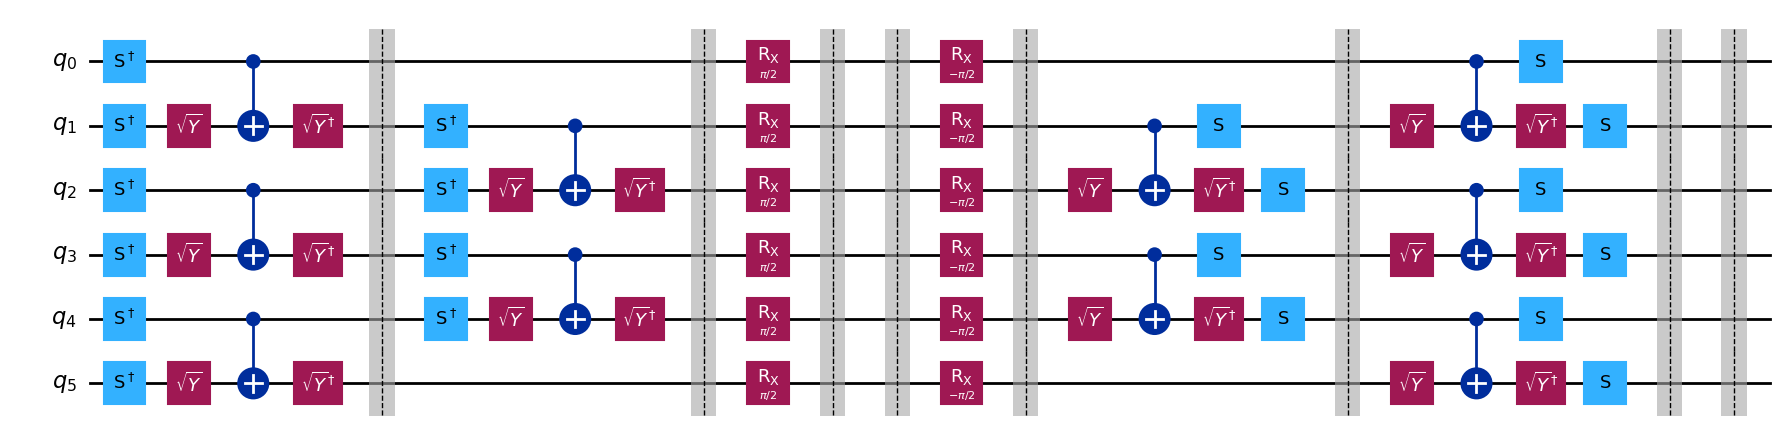

In [14]:
append_mirrored_1d_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True)
qc.draw(output='mpl', fold=1)

## Step 1: Map the problem to circuits and observables

In [16]:
max_trotter_steps = 10
num_qubits = 100
measured_qubits = [49, 50]

qc_list = []
for trotter_step in range(max_trotter_steps):
    qc = generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, num_cl_bits=len(measured_qubits), trotter_barriers=True, layer_barriers=True)
    append_mirrored_1d_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True)
    qc.measure(measured_qubits, list(range(len(measured_qubits))))
    qc_list.append(qc)

## Step 2: Optimize

In [17]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
backend_name = 'ibm_brisbane'
#backend = QiskitRuntimeService().least_busy(simulator=False, operational=True, min_num_qubits=100)
print("Done getting the backend")
backend = service.backend(name=backend_name)

qc_transpiled_list = transpile(qc_list, backend=backend, optimization_level=1)


management.get:WARNING:2025-10-05 21:09:13,322: Loading default saved account
qiskit_runtime_service.__init__:WARNING:2025-10-05 21:09:16,391: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: OneInstance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-10-05 21:09:16,394: Using instance: OneInstance, plan: open


Done getting the backend


## Step 3: Execute on hardware

In [18]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(mode=backend)
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"

job = sampler.run(qc_transpiled_list)
print(job.job_id())

d3hc4qhi8kms738tdi3g


## Step 4: Post-processing and plotting

In [19]:


job_id = "d3hc4qhi8kms738tdi3g"
service = QiskitRuntimeService()
job = service.job(job_id)

survival_probability_list = []
for trotter_step in range(max_trotter_steps):
    try:
        data = job.result()[trotter_step].data
        survival_probability_list.append(data.c.get_counts()['0' * len(measured_qubits)] / data.c.num_shots)
    except:
        survival_probability_list.append(0)



management.get:WARNING:2025-10-05 21:10:32,441: Loading default saved account
qiskit_runtime_service.__init__:WARNING:2025-10-05 21:10:34,802: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: OneInstance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().


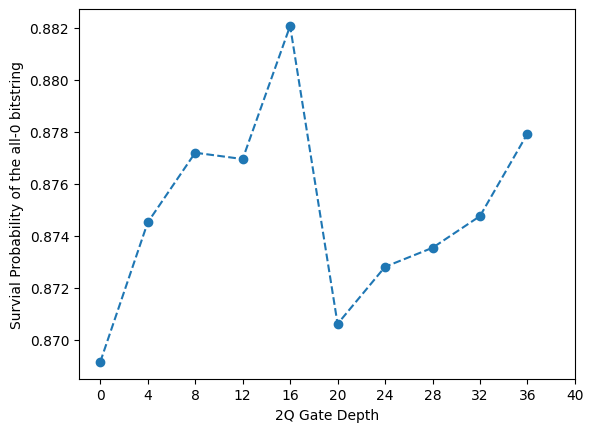

In [20]:
import matplotlib.pyplot as plt

plt.plot(list(range(0, 4*max_trotter_steps, 4)), survival_probability_list, '--o')
plt.xlabel('2Q Gate Depth')
plt.ylabel('Survial Probability of the all-0 bitstring')
plt.xticks(np.arange(0,44,4))
plt.show()


# Estimator

## Step 1: Mapping the problem

In [22]:
from qiskit.circuit import Parameter

rx_angle = Parameter("rx_angle")
trotter_steps = 2
qc = generate_1d_tfim_circuit(num_qubits, trotter_steps, rx_angle)

from qiskit.quantum_info import SparsePauliOp

middle_index = num_qubits // 2
observable = SparsePauliOp("I"*middle_index + "Z" + "I"*(middle_index-1))

## Step 2: Optimize the circuit

In [23]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService

backend_name = 'ibm_brisbane'
service = QiskitRuntimeService()
backend = service.backend(name=backend_name)
qc_transpiled = transpile(qc, backend=backend, optimization_level=1)
observable = observable.apply_layout(qc_transpiled.layout)


management.get:WARNING:2025-10-05 21:17:38,276: Loading default saved account
qiskit_runtime_service.__init__:WARNING:2025-10-05 21:17:40,788: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: OneInstance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-10-05 21:17:40,789: Using instance: OneInstance, plan: open


## Step 3: Execute on quantum hardware

In [25]:
from qiskit_ibm_runtime import EstimatorV2, EstimatorOptions

min_rx_angle = 0
max_rx_angle = np.pi/2
num_rx_angle = 12
rx_angle_list = np.linspace(min_rx_angle, max_rx_angle, num_rx_angle)

options = EstimatorOptions()
options.resilience_level = 1
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"

estimator = EstimatorV2(mode=backend, options=options)

job = estimator.run([(qc_transpiled, observable, rx_angle_list)])
print(job.job_id())

d3hca11i8kms738tdneg


## Step 4: Post-processing and plotting

(-0.1, 1.1)

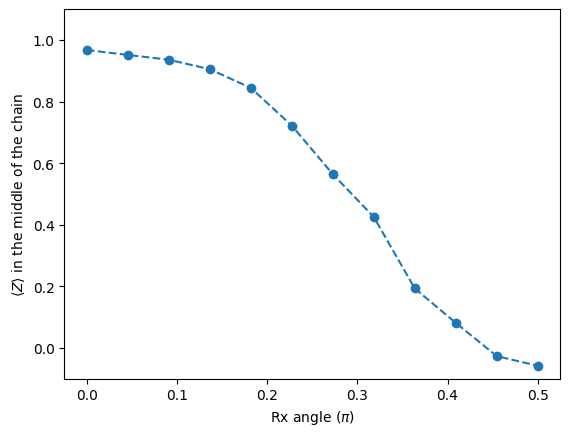

In [29]:
job_id = "d3hca11i8kms738tdneg"
job = service.job(job_id)

exp_val_list = job.result()[0].data.evs

plt.plot(rx_angle_list / np.pi, exp_val_list, '--o')
plt.xlabel(r'Rx angle ($\pi$)')
plt.ylabel(r'$\langle Z \rangle$ in the middle of the chain')
plt.ylim(-0.1, 1.1)

